In [1]:
import pandas as pd
import numpy as np
import pickle

from typing import List
from fastapi import FastAPI
# from schema import PostGet
from sqlalchemy import create_engine
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve, RocCurveDisplay
# from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
SEED = 42

In [32]:
engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

user_data_df = pd.read_sql(
    """SELECT * FROM user_data """,
    con=engine
)

post_text_df = pd.read_sql(
    """SELECT * FROM post_text_df """,
    con=engine
)

feed_data_df = pd.read_sql(
    """SELECT * FROM feed_data LIMIT 6500000 """,
    con=engine
)

In [33]:
print(user_data_df.head())
print(post_text_df.head())
print(feed_data_df.head())

   user_id  gender  age country               city  exp_group       os source
0      200       1   34  Russia          Degtyarsk          3  Android    ads
1      201       0   37  Russia             Abakan          0  Android    ads
2      202       1   17  Russia           Smolensk          4  Android    ads
3      203       0   18  Russia             Moscow          1      iOS    ads
4      204       0   36  Russia  Anzhero-Sudzhensk          3  Android    ads
   post_id                                               text     topic
0        1  UK economy facing major risks\n\nThe UK manufa...  business
1        2  Aids and climate top Davos agenda\n\nClimate c...  business
2        3  Asian quake hits European shares\n\nShares in ...  business
3        4  India power shares jump on debut\n\nShares in ...  business
4        5  Lacroix label bought by US firm\n\nLuxury good...  business
            timestamp  user_id  post_id action  target
0 2021-11-22 12:19:11   154877     1119   vie

In [34]:
feed_data_df = feed_data_df.loc[feed_data_df['action'] != 'like']

In [35]:
feed_data_df = feed_data_df.drop(['action'], axis=1)

In [36]:
df = feed_data_df.join(post_text_df.set_index('post_id'), on='post_id')

In [37]:
df = df.join(user_data_df.set_index('user_id'), on='user_id')

In [38]:
df = df.drop('text', axis=1)

In [39]:
df['ts'] = df[['timestamp']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
df = df.drop('timestamp', axis = 1)
df.rename(columns = ({'ts':'timestamp'}), inplace = True)
df.sort_values(by='timestamp', inplace=True)

In [40]:
df.head()

,user_id,post_id,target,topic,gender,age,country,city,exp_group,os,source,timestamp
4339458,134967,5272,0,movie,1,21,Russia,Moscow,3,Android,organic,1633068112
3955986,141770,583,0,entertainment,0,27,Russia,Astrakhan,0,Android,organic,1633068112
4310521,51731,3855,0,covid,1,33,Russia,Novosibirsk,2,Android,ads,1633068112
2719163,85946,5305,0,movie,1,22,Russia,Nar’yan-Mar,3,Android,ads,1633068112
3186424,114567,3644,0,covid,0,20,Russia,Kudryashovskiy,0,Android,organic,1633068112


In [41]:
df = df.reset_index()
df = df.drop('index', axis=1)
df.head()

,user_id,post_id,target,topic,gender,age,country,city,exp_group,os,source,timestamp
0,134967,5272,0,movie,1,21,Russia,Moscow,3,Android,organic,1633068112
1,141770,583,0,entertainment,0,27,Russia,Astrakhan,0,Android,organic,1633068112
2,51731,3855,0,covid,1,33,Russia,Novosibirsk,2,Android,ads,1633068112
3,85946,5305,0,movie,1,22,Russia,Nar’yan-Mar,3,Android,ads,1633068112
4,114567,3644,0,covid,0,20,Russia,Kudryashovskiy,0,Android,organic,1633068112


In [42]:
train = df.iloc[:int(df.shape[0] * 4/5)].copy()
test = df.iloc[int(df.shape[0] * 4/5):].copy()

In [43]:
# train[mte_columns] = TargetEncoder().fit_transform(train[mte_columns], train['target'])

# train[num_columns] = StandardScaler().fit_transform(train[num_columns])
# test[num_columns] = StandardScaler().fit_transform(test[num_columns])

In [44]:
train

,user_id,post_id,target,topic,gender,age,country,city,exp_group,os,source,timestamp
0,134967,5272,0,movie,1,21,Russia,Moscow,3,Android,organic,1633068112
1,141770,583,0,entertainment,0,27,Russia,Astrakhan,0,Android,organic,1633068112
2,51731,3855,0,covid,1,33,Russia,Novosibirsk,2,Android,ads,1633068112
3,85946,5305,0,movie,1,22,Russia,Nar’yan-Mar,3,Android,ads,1633068112
4,114567,3644,0,covid,0,20,Russia,Kudryashovskiy,0,Android,organic,1633068112
...,...,...,...,...,...,...,...,...,...,...,...,...
4644649,155021,3199,0,covid,1,38,Russia,Mednogorsk,4,Android,organic,1639258563
4644650,99167,293,0,business,1,45,Russia,Zhukovka,1,Android,ads,1639258564
4644651,20354,6403,0,movie,1,39,Russia,Gukovo,3,iOS,ads,1639258564
4644652,85254,445,0,business,0,28,Russia,Zelënodol’sk,3,iOS,ads,1639258564


In [55]:
X_train = train.drop(['target'],  axis = 1)
X_test = test.drop(['target'],  axis = 1)

y_train = train['target']
y_test = test['target']

In [56]:
# obj_columns = df.loc[:, df.dtypes == object].columns

# ohe_columns = [col for col in obj_columns if df[col].nunique() < 20]
# num_columns = list(df.select_dtypes(exclude='object').columns)

# ohe_columns_idx = [list(df.columns).index(col) for col in ohe_columns]
# mte_columns_idx = [list(df.columns).index(col) for col in mte_columns]
# num_columns_idx = [list(df.columns).index(col) for col in num_columns]

In [57]:
for col in ['topic', 'country', 'exp_group', 'os', 'source']:
    one_hot_train = pd.get_dummies(X_train[col], prefix=col, drop_first=True)
    X_train = pd.concat((X_train.drop(col, axis=1), one_hot_train), axis=1)
    one_hot_test = pd.get_dummies(X_test[col], prefix=col, drop_first=True)
    X_test = pd.concat((X_test.drop(col, axis=1), one_hot_test), axis=1)

In [58]:
X_train['city'] = LabelEncoder().fit_transform(X_train['city'])
X_test['city'] = LabelEncoder().fit_transform(X_test['city'])

In [59]:
X_train = X_train.drop(['timestamp'], axis=1)
X_test = X_test.drop(['timestamp'], axis=1)

In [60]:
print(f'Train class 1: {len(y_train[y_train == 1])}')
print(f'Train class 0: {len(y_train[y_train == 0])}')
print(f'Test class 1: {len(y_test[y_test == 1])}')
print(f'Test class 0: {len(y_test[y_test == 0])}')

Train class 1: 534507
Train class 0: 4110147
Test class 1: 159678
Test class 0: 1001486


In [61]:
def func_predictive(y_test, X_test, model):
    roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    auc(fpr, tpr)

Learning rate set to 0.379073
0:	learn: 0.6809564	total: 1.06s	remaining: 17m 39s
100:	learn: 0.6507368	total: 46.6s	remaining: 6m 54s
200:	learn: 0.6477808	total: 1m 30s	remaining: 6m
300:	learn: 0.6458997	total: 2m 16s	remaining: 5m 16s
400:	learn: 0.6444860	total: 3m 2s	remaining: 4m 32s
500:	learn: 0.6433235	total: 3m 49s	remaining: 3m 48s
600:	learn: 0.6423253	total: 4m 36s	remaining: 3m 3s
700:	learn: 0.6414186	total: 5m 24s	remaining: 2m 18s
800:	learn: 0.6405662	total: 6m 12s	remaining: 1m 32s
900:	learn: 0.6397778	total: 7m 1s	remaining: 46.3s
999:	learn: 0.6390219	total: 7m 49s	remaining: 0us


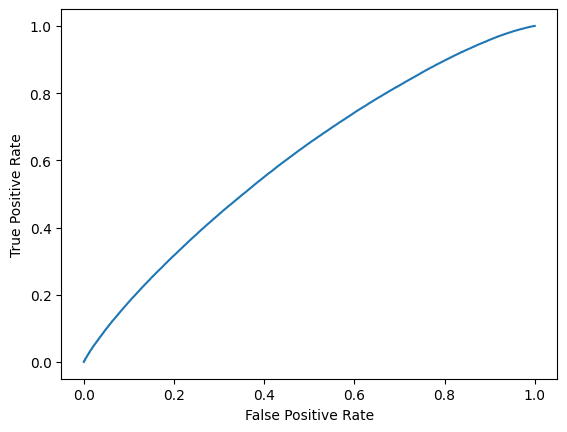

In [62]:
catboost = CatBoostClassifier(verbose=100, random_seed=SEED, scale_pos_weight=round((y_test == 0).sum()/(y_test == 1).sum(), 3))

catboost.fit(X_train, y_train)

func_predictive(y_test=y_test, X_test=X_test, model=catboost)

In [63]:
catboost.save_model('catboost', format="cbm")

In [53]:
users_posts = pd.read_sql(
    """
    SELECT DISTINCT ON (user_id) user_id, post_id
    FROM "feed_data"
    """,
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml")

In [38]:
nfrv_nikita_features_lesson_22 = users_posts.join(post_text_df.set_index('post_id'), on='post_id')
# nfrv_nikita_features_lesson_22 = nfrv_nikita_features_lesson_22.join(user_data_df.set_index('user_id'), on='user_id')

In [39]:
nfrv_nikita_features_lesson_22.head()

,user_id,post_id,text,topic,gender,age,country,city,exp_group,os,source
0,200,2246,Games help you learn and play\n\nGod games in ...,tech,1,34,Russia,Degtyarsk,3,Android,ads
1,201,2339,Day 234: #365daysofgraterfulness i did a lot o...,covid,0,37,Russia,Abakan,0,Android,ads
2,202,6927,I just wanna say that amongst all the so-calle...,movie,1,17,Russia,Smolensk,4,Android,ads
3,203,1760,Mourinho takes swipe at Arsenal\n\nChelsea bos...,sport,0,18,Russia,Moscow,1,iOS,ads
4,204,5387,"This movie, with all its complexity and subtle...",movie,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [40]:
nfrv_nikita_features_lesson_22 = nfrv_nikita_features_lesson_22.drop('text', axis=1)

In [41]:
for col in ['country', 'exp_group', 'os', 'source', 'topic']:
    one_hot = pd.get_dummies(nfrv_nikita_features_lesson_22[col], prefix=col, drop_first=True)
    nfrv_nikita_features_lesson_22 = pd.concat((nfrv_nikita_features_lesson_22.drop(col, axis=1), one_hot), axis=1)


nfrv_nikita_features_lesson_22['city'] = LabelEncoder().fit_transform(nfrv_nikita_features_lesson_22['city'])

In [42]:
feature_en_df = nfrv_nikita_features_lesson_22.set_index(['user_id', 'post_id'])

In [43]:
feature_en_df.head()

,,gender,age,city,country_Belarus,country_Cyprus,country_Estonia,country_Finland,country_Kazakhstan,country_Latvia,country_Russia,...,exp_group_3,exp_group_4,os_iOS,source_organic,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
200,2246,1,34,651,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
201,2339,0,37,2,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
202,6927,1,17,2931,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
203,1760,0,18,1953,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
204,5387,0,36,125,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


In [44]:
feature_en_df.shape

(163205, 25)

In [46]:
feature_en_df.to_sql('nfrv_nikita_features_lesson_22', con=engine, if_exists='replace')

205

In [ ]:
df = pd.read_sql(
    'SELECT * FROM nfrv_nikita_features_lesson_22', 
    con=engine
    )

In [ ]:
df.head()

,user_id,post_id,gender,age,city,country_Belarus,country_Cyprus,country_Estonia,country_Finland,country_Kazakhstan,...,exp_group_3,exp_group_4,os_iOS,source_organic,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,200,167,1,34,651,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,201,4368,0,37,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,202,6927,1,17,2931,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,203,1760,0,18,1953,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,204,5387,0,36,125,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [ ]:
df.shape

(163205, 27)